# Lab3 Simplified: PPR Data Understanding

本笔记本仅保留适用于 `ppr-group-25208508-train.csv` 的数据理解与数据质量检查代码，便于快速跑通并查看数据情况。


## 1) Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 140)

sns.set_style('whitegrid')


## 2) Load Dataset


In [2]:
file_path = 'ppr-group-25208508-train.csv'
df = pd.read_csv(file_path, encoding='utf-8')

print(f'Loaded: {file_path}')
print(f'Shape: {df.shape}')
display(df.head())


Loaded: ppr-group-25208508-train.csv
Shape: (54000, 9)


,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,30/09/2016,"28 BRACKEN COURT, DONNYBROOK, CORK",Cork,NaN,"€181,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,20/12/2016,"2 AN CLOCHAR, CONVENT RD, DONERAILE",Cork,NaN,"€50,152.49",No,Yes,New Dwelling house /Apartment,less than 38 sq metres
2,28/09/2016,"Apartment 7 The Court, Clonattin, Gorey",Wexford,NaN,"€62,171.81",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
3,16/09/2016,"6 Monalin, Wicklow Hills, Newtownmountkennedy",Wicklow,NaN,"€223,348.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
4,29/01/2016,"18 Lislea, Frascati Park, Blackrock",Dublin,NaN,"€310,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


## 3) Basic Structure Check


In [8]:

print('Data types:')
display(df.dtypes.to_frame('dtype'))

print('Missing values:')
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame('missing_count'))

print('Cardinality / Top 5 Frequency:')
profile_rows = []
for c in df.columns:
    s = df[c]
    non_null_count = int(s.notna().sum())
    cardinality = int(s.nunique(dropna=True))

    vc = s.value_counts(dropna=True).head(5)
    top5_values = ' | '.join([str(v) for v in vc.index])
    top5_counts = ' | '.join([str(int(v)) for v in vc.values])
    top5_freq = ' | '.join([
        str(round((int(v) / non_null_count) * 100, 2)) if non_null_count > 0 else '0.0'
        for v in vc.values
    ])

    profile_rows.append({
        'feature': c,
        'non_null_count': non_null_count,
        'cardinality': cardinality,
        'top5_values': top5_values,
        'top5_counts': top5_counts,
        'top5_freq_%': top5_freq
    })

profile_df = pd.DataFrame(profile_rows).sort_values(['cardinality', 'non_null_count'], ascending=[False, False])
display(profile_df)



Data types:


,dtype
Date of Sale (dd/mm/yyyy),str
Address,str
County,str
Eircode,str
Price (€),str
Not Full Market Price,str
VAT Exclusive,str
Description of Property,str
Property Size Description,str


Missing values:


,missing_count
Property Size Description,51164
Eircode,37108
Date of Sale (dd/mm/yyyy),0
Address,0
County,0
Price (€),0
Not Full Market Price,0
VAT Exclusive,0
Description of Property,0


Cardinality / Top 5 Frequency:


,feature,non_null_count,cardinality,top5_values,top5_counts,top5_freq_%
1,Address,54000,53261,"AUGHNASEDA, MONAGHAN | ERREW, CASTLEHILL, BALL...",5 | 4 | 3 | 3 | 3,0.01 | 0.01 | 0.01 | 0.01 | 0.01
3,Eircode,16892,16823,D24W9NN | F45FN32 | D24YT67 | H91DNF4 | D02R658,4 | 2 | 2 | 2 | 2,0.02 | 0.01 | 0.01 | 0.01 | 0.01
4,Price (€),54000,6845,"€150,000.00 | €250,000.00 | €200,000.00 | €300...",619 | 596 | 577 | 492 | 486,1.15 | 1.1 | 1.07 | 0.91 | 0.9
0,Date of Sale (dd/mm/yyyy),54000,2487,18/12/2020 | 21/12/2020 | 22/12/2020 | 20/12/2...,107 | 102 | 97 | 95 | 89,0.2 | 0.19 | 0.18 | 0.18 | 0.16
2,County,54000,26,Dublin | Cork | Kildare | Galway | Meath,16592 | 5975 | 2926 | 2600 | 2325,30.73 | 11.06 | 5.42 | 4.81 | 4.31
8,Property Size Description,2836,4,greater than or equal to 38 sq metres and less...,2105 | 507 | 131 | 93,74.22 | 17.88 | 4.62 | 3.28
7,Description of Property,54000,3,Second-Hand Dwelling house /Apartment | New Dw...,44332 | 9665 | 3,82.1 | 17.9 | 0.01
5,Not Full Market Price,54000,2,No | Yes,51150 | 2850,94.72 | 5.28
6,VAT Exclusive,54000,2,No | Yes,44486 | 9514,82.38 | 17.62


## 4) Data Type Preparation (PPR-specific)


In [9]:
# Date parsing
if 'Date of Sale (dd/mm/yyyy)' in df.columns:
    df['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(
        df['Date of Sale (dd/mm/yyyy)'],
        dayfirst=True,
        errors='coerce'
    )


# Convert price to numeric (remove currency symbols and separators)
if 'Price (€)' in df.columns:
    df['Price (€)'] = (
        df['Price (€)']
        .astype(str)
        .str.replace('€', '', regex=False)
        .str.replace(',', '', regex=False)
        .str.strip()
        .replace({'': np.nan, 'nan': np.nan})
    )
    df['Price (€)'] = pd.to_numeric(df['Price (€)'], errors='coerce')

# Convert common binary text fields to category for cleaner profiling
for col in ['Not Full Market Price', 'VAT Exclusive', 'County', 'Description of Property', 'Property Size Description']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Create simple date features for quick inspection
if 'Date of Sale (dd/mm/yyyy)' in df.columns:
    df['Sale Year'] = df['Date of Sale (dd/mm/yyyy)'].dt.year
    df['Sale Month'] = df['Date of Sale (dd/mm/yyyy)'].dt.month

print('Updated dtypes:')
display(df.dtypes.to_frame('dtype'))


Updated dtypes:


,dtype
Date of Sale (dd/mm/yyyy),datetime64[us]
Address,str
County,category
Eircode,str
Price (€),float64
Not Full Market Price,category
VAT Exclusive,category
Description of Property,category
Property Size Description,category
Sale Year,int32


## 5) Duplicates and Constant Columns


In [10]:
duplicate_count = df.duplicated().sum()
print(f'Duplicate rows: {duplicate_count}')

constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print(f'Constant columns ({len(constant_cols)}): {constant_cols}')


Duplicate rows: 9
Constant columns (0): []


## 6) Numeric and Categorical Summaries


In [12]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical/date columns:', cat_cols)

if numeric_cols:
    print('Numeric summary:')
    display(df[numeric_cols].describe().T)


Numeric columns: ['Price (€)', 'Sale Year', 'Sale Month']
Categorical/date columns: ['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Eircode', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description']
Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Price (€),54000.0,340638.819917,1.662132e+06,5250.0,157000.0,250000.0,365000.0,225000000.0
Sale Year,54000.0,2020.000000,2.582013e+00,2016.0,2018.0,2020.0,2022.0,2024.0
Sale Month,54000.0,7.062259,3.457741e+00,1.0,4.0,7.0,10.0,12.0


## 7) Cardinality Values Analysis

In [14]:
exclude_cols = ['Date of Sale (dd/mm/yyyy)', 'Eircode']
analysis_cols = [c for c in cat_cols if c not in exclude_cols]

cat_summary = []
for c in analysis_cols:
    s = df[c]
    non_null_count = int(s.notna().sum())
    cardinality = int(s.nunique(dropna=True))

    vc = s.value_counts(dropna=True)
    top_value = vc.index[0] if len(vc) > 0 else np.nan
    top_count = int(vc.iloc[0]) if len(vc) > 0 else 0
    top_freq_pct = round((top_count / non_null_count) * 100, 2) if non_null_count > 0 else 0.0

    cat_summary.append({
        'feature': c,
        'dtype': str(s.dtype),
        'non_null_count': non_null_count,
        'missing_count': int(s.isna().sum()),
        'missing_%': round(s.isna().mean() * 100, 2),
        'cardinality': cardinality,
        'top_value': top_value,
        'top_count': top_count,
        'top_freq_%': top_freq_pct
    })

cat_summary_df = pd.DataFrame(cat_summary).sort_values(['missing_%', 'cardinality'], ascending=[False, False])
display(cat_summary_df)

# Frequency table (Top 10) for selected categorical columns only
for c in analysis_cols:
    print(f"\n=== {c} | cardinality={df[c].nunique(dropna=True)} | non_null={df[c].notna().sum()} ===")
    freq_df = (
        df[c]
        .value_counts(dropna=False)
        .rename_axis('value')
        .reset_index(name='count')
    )
    freq_df['frequency_%'] = (freq_df['count'] / len(df) * 100).round(2)
    display(freq_df.head(10))



,feature,dtype,non_null_count,missing_count,missing_%,cardinality,top_value,top_count,top_freq_%
5,Property Size Description,category,2836,51164,94.75,4,greater than or equal to 38 sq metres and less...,2105,74.22
0,Address,str,54000,0,0.00,53261,"AUGHNASEDA, MONAGHAN",5,0.01
1,County,category,54000,0,0.00,26,Dublin,16592,30.73
4,Description of Property,category,54000,0,0.00,3,Second-Hand Dwelling house /Apartment,44332,82.10
2,Not Full Market Price,category,54000,0,0.00,2,No,51150,94.72
3,VAT Exclusive,category,54000,0,0.00,2,No,44486,82.38



=== Address | cardinality=53261 | non_null=54000 ===


,value,count,frequency_%
0,"AUGHNASEDA, MONAGHAN",5,0.01
1,"ERREW, CASTLEHILL, BALLINA",4,0.01
2,"BRAMBLE COTTAGE, NEWMARKET ON FERGUS, CO CLARE",3,0.01
3,"MAIN ST, STRADBALLY, LAOIS",3,0.01
4,"85 KILLEEN WOOD, TRALEE, KERRY",3,0.01
5,"STRADBALLY EAST, CLARINBRIDGE, GALWAY",3,0.01
6,"THE HATCHERY, HATCHERY LANE, INISTIOGE",3,0.01
7,"52 ROCKBARTON PARK, SALTHILL, GALWAY",3,0.01
8,"MCCURTAIN ST, CLONES, MONAGHAN",3,0.01
9,"FARRNASTACK, LISSELTON, CO KERRY",3,0.01



=== County | cardinality=26 | non_null=54000 ===


,value,count,frequency_%
0,Dublin,16592,30.73
1,Cork,5975,11.06
2,Kildare,2926,5.42
3,Galway,2600,4.81
4,Meath,2325,4.31
5,Limerick,2063,3.82
6,Wicklow,1924,3.56
7,Wexford,1883,3.49
8,Tipperary,1538,2.85
9,Louth,1534,2.84



=== Not Full Market Price | cardinality=2 | non_null=54000 ===


,value,count,frequency_%
0,No,51150,94.72
1,Yes,2850,5.28



=== VAT Exclusive | cardinality=2 | non_null=54000 ===


,value,count,frequency_%
0,No,44486,82.38
1,Yes,9514,17.62



=== Description of Property | cardinality=3 | non_null=54000 ===


,value,count,frequency_%
0,Second-Hand Dwelling house /Apartment,44332,82.10
1,New Dwelling house /Apartment,9665,17.90
2,Teach/Árasán Cónaithe Atháimhe,3,0.01



=== Property Size Description | cardinality=4 | non_null=2836 ===


,value,count,frequency_%
0,NaN,51164,94.75
1,greater than or equal to 38 sq metres and less...,2105,3.90
2,greater than or equal to 125 sq metres,507,0.94
3,less than 38 sq metres,131,0.24
4,greater than 125 sq metres,93,0.17


## 8) Quick Visual Checks on Price Distribution


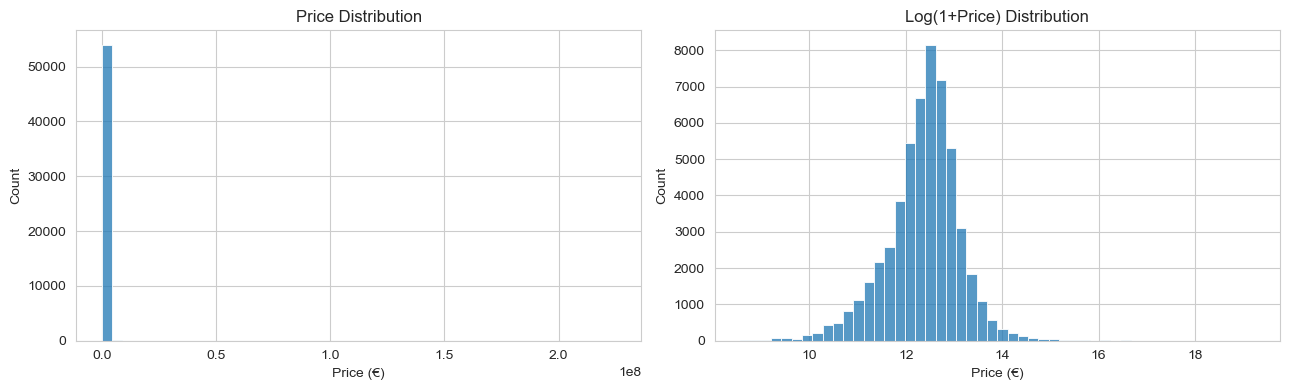

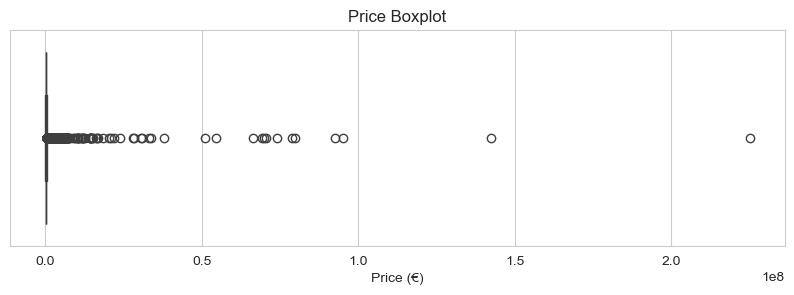

In [15]:
# Price distribution (target)
price_col = 'Price (€)'
if price_col in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    sns.histplot(df[price_col].dropna(), bins=50, ax=axes[0])
    axes[0].set_title('Price Distribution')

    sns.histplot(np.log1p(df[price_col].dropna()), bins=50, ax=axes[1])
    axes[1].set_title('Log(1+Price) Distribution')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2.8))
    sns.boxplot(x=df[price_col])
    plt.title('Price Boxplot')
    plt.show()


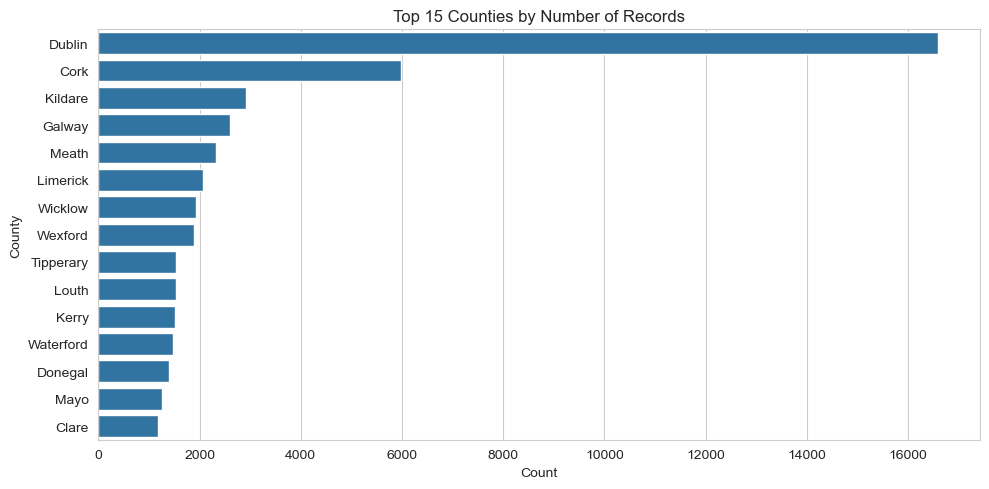

Property Size Description - NaN count: 51164, NaN %: 94.75


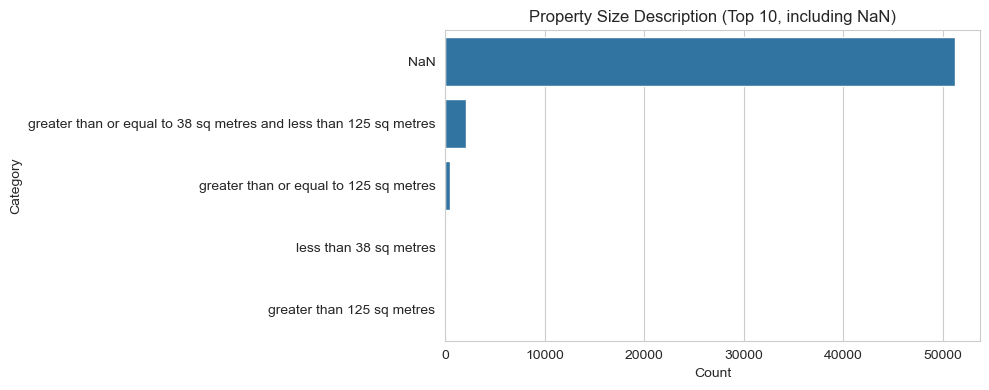

In [17]:
# Top counties by record count
if 'County' in df.columns:
    top_county = df['County'].astype(str).value_counts().head(15)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_county.values, y=top_county.index)
    plt.title('Top 15 Counties by Number of Records')
    plt.xlabel('Count')
    plt.ylabel('County')
    plt.tight_layout()
    plt.show()

# Property size description distribution (+ NaN info)
if 'Property Size Description' in df.columns:
    missing_count = int(df['Property Size Description'].isna().sum())
    missing_pct = round(df['Property Size Description'].isna().mean() * 100, 2)
    print(f"Property Size Description - NaN count: {missing_count}, NaN %: {missing_pct}")

    top_size = (
        df['Property Size Description']
        .astype('object')
        .fillna('NaN')
        .value_counts()
        .head(10)
    )
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_size.values, y=top_size.index)
    plt.title('Property Size Description (Top 10, including NaN)')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()



## 9) Save a Cleaned Preview CSV (Optional)


In [19]:
# Keep this as a preview output for your own checks
out_file = 'ppr-group-25208508-train-lab3-preview.csv'
df.to_csv(out_file, index=False, encoding='utf-8')
print(f'Saved: {out_file}')


Saved: ppr-group-25208508-train-lab3-preview.csv
